In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy import sparse
import time
import pickle
import json
import os

In [6]:
test_file = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/lihc_protein_coding_gene_std_exp_profile.txt'
exp_profile = pd.read_csv(test_file,sep='\t',index_col = 0)
gene_list = list(exp_profile.index)
biomart = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/data/exp_profile/biomart_protein_coding_gene.txt",sep='\t')
#import go graph
graph_d = dict()
graph_path = '/home/bruce1996/data/GO/networkx/'
go_field = ['biological_process','cellular_component','molecular_function']
for field in go_field :
    file = graph_path + field + '.go'
    with open(file , 'rb') as f:  # notice the r instead of w
        graph_d[field] = pickle.load(f)
        f.close()

with open("/home/bruce1996/data/GO/go2namespace.json",'rb') as f :
    go2namespace = json.load(f)
    f.close()

In [19]:
import seaborn as sns 
import matplotlib.pyplot as plt

corr_m = exp_profile.T.corr(method='spearman')
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
plot_df = corr_m.stack().reset_index()
plot_df.columns = ['Row','Column','Value']
# plot heatmap
sns.clustermap(plot_df,cmap=cmap, vmin=-1, vmax=1,  cbar_kws={"shrink": .8},pivot_kws={'index': plot_df.columns[0],
                                    'columns': plot_df.columns[1], 
                                  'values': plot_df.columns[2]})
plt.savefig('/home/bruce1996/data/LIHC_anomaly_detection/fig/lihc_gene2gene_scc.png')

In [6]:
experiment_evidence_code = ['EXP','IDA','IPI','IMP','IGI','IEP','HTP','HDA','HMP','HGI','HEP']
idx = [x in experiment_evidence_code for x in biomart['GO term evidence code']]
biomart = biomart.loc[idx,:]

In [7]:
from validation_edge import create_gene2go_matrix

gene2go_matrix,goindex = create_gene2go_matrix(biomart,exp_profile,graph_d,threads = 10)
index2go = np.array(list(goindex.keys()))
gene2go_matrix = gene2go_matrix.tocsc()

Number of GO with validated evidence code : 12515

### remove GO by GO level

In [9]:
def get_go_level(go,go2namespace,graph_dict) :
    if go not in go2namespace.keys() :
        return -1
    field = go2namespace[go]
    root = graph_dict[field]
    return root.nodes[go]['Level']

In [10]:
threshold = 5 
go_level = np.zeros(gene2go_matrix.shape[1])
for idx,go in enumerate(index2go) :
    go_level[idx] = get_go_level(go,go2namespace,graph_d)

idx = np.where(go_level >= threshold,1,0)
D = sparse.diags(idx, dtype=gene2go_matrix.dtype)
gene2go_matrix_level = gene2go_matrix * D
index2go[idx] = 'NA'

Number of GO term level >= 5 : 8406

In [40]:
def create_go2gene_dict(gene2go_matrix,gene_list,go_list) :
    go2gene_dict = dict()
    for i in range(gene2go_matrix.shape[1]) :
        if gene2go_matrix[:,i].count_nonzero() > 0 :
            gene_idx = gene2go_matrix.nonzero()[0]
            go2gene_dict[go_list[i]] = gene_list[gene_idx]
        else :
            pass
    return go2gene_dict

In [41]:
gene_list = np.array(exp_profile.index)
go2gene_dict = create_go2gene_dict(gene2go_matrix_level,gene_list,index2go)

In [46]:
import pickle
with open('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/go2gene_dict.pkl','wb') as f :
    pickle.dump(go2gene_dict,f)
f.close()

### gene-based GO fisher exact test

In [17]:
from scipy import sparse
from scipy.stats import fisher_exact
from math import comb

def gene_based_fisher_exact_test(gene2go_matrix,vote_result,go_index) :
    '''
    gene2go_matrix : scipy sparse matrx (csc of dok), row is gene , column is GO
    vote_result : scipy csc matrix
    '''
    matrix = gene2go_matrix.getcol(go_index)
    if matrix.count_nonzero() == 0 :
        p = 999
        return p
    intersection,_ = matrix.nonzero()
    vote,_ = vote_result.nonzero()
    g1 = len(np.intersect1d(intersection,vote))
    g2 = len(intersection) - g1
    g3 = len(vote) - g1
    g4 = gene2go_matrix.shape[0] - len(intersection - g3)

    fisher_table = np.array([[g1,g2],[g3,g4]])
    try :
        oddsr, p = fisher_exact(fisher_table, alternative='two-sided')
    except ValueError :
        print("Error occur in fisher exact test stage !")
        p = 999

    return p

In [18]:
vote = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/lihc_ensemble_learning_gene_vote.txt',sep='\t',index_col=0)
vote = vote.loc[exp_profile.index,:]
vote_m = vote.to_numpy()
vote_csc = sparse.csc_matrix(vote_m)
vote_csc.eliminate_zeros()

In [ ]:
n = gene2go_matrix.shape[1]
gene_fisher_pv = np.zeros(n)
s = time.time()
for i in range(n) :
    gene_fisher_pv[i] = gene_based_fisher_exact_test(gene2go_matrix_level,vote_csc,i)
    if i % 1000 == 0 :
        print('Number of %d GO fisher exact test is processed !' % i)
e = time.time()
delta = e -s
print("Execution time of gene based fisher exact test is %0.2f" % delta)

idx = np.where(gene_fisher_pv < 0.05,1,0)
D = sparse.diags(idx, dtype=gene2go_matrix_level.dtype)
gene2go_matrix_pass_gene = gene2go_matrix_level * D

Number of GO pass gene-based fisher exact test : 986

### pesudo code of edge-based fisher exact test

In [22]:
from scipy import sparse
from scipy.stats import fisher_exact
from math import comb

def corr_2_sparse_matrix(corr_matrix,threshold=0.4) :
    corr_matrix = np.tril(corr_matrix)
    idx = corr_matrix >= threshold
    corr_matrix[~idx] = 0
    np.fill_diagonal(corr_matrix,0)
    corr_csc = sparse.csc_matrix(corr_matrix)
    corr_csc.eliminate_zeros()
    return corr_csc

def sum_csc_matrix(matrix,index) :
    tmp = matrix[:,index]
    tmp = tmp.tocsr()
    nonzero = 0
    for i in index :
        nonzero +=  tmp.getrow(i).count_nonzero()
    del tmp
    return nonzero

def edge_fisher_exact_test(gene2go_matrix,corr_matrix,go_index) :
    
    matrix = gene2go_matrix.getcol(go_index)
    if matrix.count_nonzero() == 0 :
        p = 999 
        return p
    else :
        #GO involved gene set
        gene_idx,_ = matrix.nonzero()
        num_gene_involved = len(gene_idx)
        m = corr_matrix[gene_idx][:,gene_idx]
        e1 = m.count_nonzero()
        #e1 = sum_csc_matrix(corr_matrix,gene_idx)
        #e1 + e2
        total_intersection = comb(num_gene_involved,2)
        e2 = total_intersection - e1
        ### GO with intersection
        #e1 + e3
        total_corr = corr_matrix.count_nonzero()
        e3 = total_corr - e1
        n_gene = corr_matrix.shape[0]
        e4 = comb(n_gene,2) - comb(num_gene_involved,2) - e3

        fisher_table = np.array([[e1,e2],[e3,e4]])
        try :
            oddsr, p = fisher_exact(fisher_table, alternative='two-sided')
        except ValueError :
            print("Error occur in fisher exact test stage !")
            p = 999

        return p

In [ ]:
corr_csc = sparse.load_npz('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/corr_csc_matrix.npz')
n = gene2go_matrix_pass_gene.shape[1]
edge_fisher_pv = np.zeros(n)
s = time.time()
for i in range(n) :
    edge_fisher_pv[i] = edge_fisher_exact_test(gene2go_matrix_pass_gene,corr_csc,i)
    if i % 1000 == 0 :
        print('Number of %d GO fisher exact test is processed !' % i)
e = time.time()
delta = e -s
print("Execution time of gene based fisher exact test is %0.2f" % delta)

idx = np.where(edge_fisher_pv < 0.05,1,0)
D = sparse.diags(idx, dtype=gene2go_matrix_pass_gene.dtype)
gene2go_matrix_validated = gene2go_matrix_pass_gene * D

sparse.save_npz('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/validated_gene2go_matrix.npz',gene2go_matrix_validated)

number of GO pass edge-based fisher exact test : 727

### Taxonomy enrichment set analysis

In [2]:
from utils.tsea import enrich_score,permutation,taxonomy_set_enrichment_analysis
import pickle

In [3]:
gene2go_matrix_validated = sparse.load_npz('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/validated_gene2go_matrix.npz')
with open('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/validated_go2gene_dict.pkl','rb') as f :
    go_genelist = pickle.load(f)

In [4]:
with open('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/validated_go2gene_dict.pkl','wb') as f :
    pickle.dump(go_genelist,f)
f.close()

In [ ]:
idx = np.where(np.sum(gene2go_matrix_validated,axis=0)[0,:] > 0)[1]
go_list = np.array(list(goindex.keys()))
validated_go = go_list[idx]

go_genelist = dict()
missing = 0
n = 0
for g in validated_go :
    n += 1
    idx = np.where(biomart['GO term accession'].values == g,True,False)
    if sum(idx) > 0 :
        genes = biomart['Gene stable ID'][idx]
        genes = np.unique(genes)
        go_genelist[g] = genes
    else :
        missing += 1
        
    if n % 10 == 0 :
        print(n)
## or 

with open('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/validated_go2gene_dict.pkl','rb') as f :
    go_genelist = pickle.load(f)

### tsea by vote

In [14]:
with open('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/validated_go2gene_dict.pkl','rb') as f :
    go_genelist = pickle.load(f)

In [15]:
vote = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/lihc_ensemble_learning_gene_vote.txt',sep='\t',index_col=0)
vote = vote.loc[exp_profile.index,:]
vote_m = vote.to_numpy()
vote_csc = sparse.csc_matrix(vote_m)
vote_csc.eliminate_zeros()

In [ ]:
vote_ranking = list(vote.sort_values(by='Vote',ascending=False).index)
vote_tsea = taxonomy_set_enrichment_analysis(go_genelist,vote_ranking)
vote_tsea.tsea()
df = pd.DataFrame({'Pesudo-F' : vote_tsea.pesudo_f},index = list(go_genelist.keys()))
idx = np.where(df['Pesudo-F'].values < 0.05,True,False)
pass_vote_go = df.loc[idx,:].sort_values(by='Pesudo-F')
#pass_vote_go.to_csv('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/vote_tsea.txt',sep='\t')

### tsea by fold-change

In [17]:
deseq_df = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/differential_expression/coding_gene_deseq2.txt",sep='\t',index_col=0)
#activate
fc_ranking = list(deseq_df.sort_values(by='log2FoldChange',ascending=False).index)
#suppress
fc_ranking = list(deseq_df.sort_values(by='log2FoldChange').index)

In [20]:
foldchange_tsea = taxonomy_set_enrichment_analysis(go_genelist,fc_ranking)
foldchange_tsea.tsea()
df = pd.DataFrame({'Pesudo-F' : foldchange_tsea.pesudo_f},index = list(go_genelist.keys()))
idx = np.where(df['Pesudo-F'] < 0.05,True,False)
validated_df = df.loc[idx,:].sort_values(by='Pesudo-F')
validated_df.to_csv("/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/fold_change_tsea_inactivate.txt",sep='\t')

In [24]:
tsea_vote = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling//candidate_functional_module/vote_tsea.txt',sep='\t',index_col=0)
tsea_fc = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/fold_change_tsea_inactivate.txt',sep='\t',index_col=0)
final_validated_go = list(set(tsea_vote.index).intersection(tsea_fc.index))
tsea_fc.loc[final_validated_go,:].sort_values(by='Pesudo-F').to_csv('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/inactivate_candidate_go.txt',sep = '\t')

### candidate functional module vote distribution

In [24]:
with open('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/validated_go2gene_dict.pkl','rb') as f :
    go_genelist = pickle.load(f)
vote = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/lihc_ensemble_learning_gene_vote.txt',sep='\t',index_col=0)
candidate_go = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/activate_candidate_go.txt',sep = '\t',index_col=0)
plot_df = pd.DataFrame(columns=['GO','Gene','Vote'])
for go in candidate_go.index :
    gene = list(set(go_genelist[go]).intersection(vote.index))
    go_vote = vote.loc[gene,'Vote'].values
    df = pd.DataFrame({'GO' : [go] * len(gene),'Gene' : gene,'Vote' : go_vote})
    plot_df = pd.concat([plot_df,df])

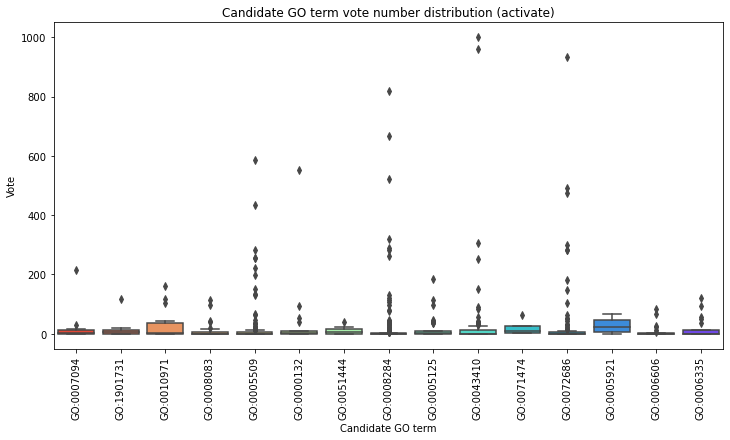

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.boxplot(data=plot_df,x='GO',y='Vote',palette='rainbow_r')
plt.xticks(rotation=90)
plt.xlabel('Candidate GO term')
plt.title("Candidate GO term vote number distribution (activate)")
plt.savefig('/home/bruce1996/data/LIHC_anomaly_detection/fig/functional_module/activate_candidate_go_vote_boxplot.png',dpi = 300,bbox_inches = 'tight',format = 'png')

### plot <br>
potential network layout <br>
https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3